# GA-DSI Project 3 

# Problem Statement 

You are a junior data scientist who was recently hired by Google to analyse big data and improve its standing and product offerings. As Cloud technology is fast arising and adopted by many companies, you decided to examine the sentiments of Google Cloud vis-a-vis that of Amazon Web Services (i.e. Google's fierce competitor in the market). 

To do so, you wanted to use a set of subreddit submissions prepared by your predecessor who had recently left Google for greener pastures. Unfortunately, upon inspection of the dataset, you realised that he had accidentally left out the identification tagging column. This makes it difficult to accurately classify the subreddits into Google Cloud and AWS. 

In order to salvage the situation and use the dataset, you would thus have to first build several Natural Language Processing (NLP) models to attempt to classify subreddit submissions (from r/googlecloud and r/aws) correctly. Following which, we will choose the best performing model using the accuracy score(i.e. percentage of observations predicted correctly).

<span style="color:teal">Interesting storyline. A little unclear as at first it seems like the goal is to improve google's standing and prouct offerings so it seems like you will look at inference value of subreddits, but later on, the emphasis is on accurate classification. If doing both, this could be made clearer. also, paragraphs along with subheaders and titles, will make this easier to read :")</span>

## Table of content

1. [Data collection](#1.-Data-collection) 
2. Data cleaning
3. Exploratory data analysis (EDA)
4. Pre-processing and modeling 
5. Conclusion and recommendations


<span style="color:teal">Can link this to respective sections below. See example. </span>

In [1]:
#Import libraries 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests, time
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

# Change setting of pandas to view all variables 
pd.set_option('max_columns',500)
pd.set_option('max_rows',500)
pd.options.display.max_colwidth = 500

### 1. Data collection 

#### 1.1 Experimentation with the pushshift api

In [2]:
#Set url to be the pushshift api 
url = "https://api.pushshift.io/reddit/search/submission"

In [3]:
#Set params to test out scrapping for 100 submissions from the googlecloud subreddit
params = {
    "subreddit" : "googlecloud",
    "size" : 100,
    "sort" : "desc"
    }

In [4]:
# Using the request library to actually scrape the data from reddit using our defined url and params. 
# Status code of 200 indicates that it is a successful scrape
res = requests.get(url, params = params)
res.status_code

200

In [5]:
# Setting the scraped data to json and examining it
posts= res.json()["data"]
posts

[{'all_awardings': [],
  'allow_live_comments': False,
  'author': 'capriciousduck',
  'author_flair_css_class': None,
  'author_flair_richtext': [],
  'author_flair_text': None,
  'author_flair_type': 'text',
  'author_fullname': 't2_4arccfm9',
  'author_patreon_flair': False,
  'author_premium': False,
  'awarders': [],
  'can_mod_post': False,
  'contest_mode': False,
  'created_utc': 1619312479,
  'domain': 'self.googlecloud',
  'full_link': 'https://www.reddit.com/r/googlecloud/comments/mxxctd/data_transfer_between_gce_instance_and_google/',
  'gildings': {},
  'id': 'mxxctd',
  'is_crosspostable': True,
  'is_meta': False,
  'is_original_content': False,
  'is_reddit_media_domain': False,
  'is_robot_indexable': True,
  'is_self': True,
  'is_video': False,
  'link_flair_background_color': '',
  'link_flair_richtext': [],
  'link_flair_text_color': 'dark',
  'link_flair_type': 'text',
  'locked': False,
  'media_only': False,
  'no_follow': True,
  'num_comments': 0,
  'num_cross

In [6]:
# Setting the scraped data into a dataframe
df= pd.DataFrame(posts)
df.columns

Index(['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_patreon_flair',
       'author_premium', 'awarders', 'can_mod_post', 'contest_mode',
       'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_richtext',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'pwls',
       'retrieved_on', 'score', 'selftext', 'send_replies', 'spoiler',
       'stickied', 'subreddit', 'subreddit_id', 'subreddit_subscribers',
       'subreddit_type', 'thumbnail', 'title', 'total_awards_received',
       'treatment_tags', 'upvote_ratio',

From our initial exercise, we have established that it is possible to scrape data from the googlecloud subreddit (limited to 100 submissions per scrape). As we would ideally like to build our NLP classifer on more data, we will next proceed to scrape 2000 submissions each from our two subreddits of interest.

#### 1.2 Actual scraping of subreddits for 2000 submissions each

In [7]:
def get_submissions(subreddit, count):
    
    submission_list = []
    current_time = 1618670367
    
    '''
    Input is the url for the pushshift api and the params of our choice (name of subreddit, 
    size of submissions and time element with which we specific the time in which we want our
    submissions to be before). To get 2000 submissions, we will have to loop through the function
    20 times with each loop using the "created_utc" of the last submission from the previous loop 
    as the time element. We also set time.sleep with a randomint to prevent reddit from thinking
    we are a bot and blocking our IP address
    '''
    for i in range(count):
        url = "https://api.pushshift.io/reddit/search/submission"
        params = {
                "subreddit": subreddit,
                "size": 100,
                "before": current_time
        }
       
        res = requests.get(url, params = params)
        print (f"Status code: {res.status_code}")
        posts = res.json()["data"]
        df = pd.DataFrame(posts)
        submission_list.append(df)
        current_time = posts[-1]["created_utc"]
        time.sleep(np.random.randint(1,3))
        
    return pd.concat(submission_list, axis=0)

       

In [8]:
# Engaging our get_submissions function for subreddit: googlecloud and count =20 to get 2000 submissions
df_googlecloud = get_submissions("googlecloud", 20)

Status code: 200
Status code: 200
Status code: 200
Status code: 200
Status code: 200
Status code: 200
Status code: 200
Status code: 200
Status code: 200
Status code: 200
Status code: 200
Status code: 525


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

<span style="color:teal">runtime error at cell above.</span>

In [ ]:
# Printing the columns for our 2000 submissions
df_googlecloud.columns

In [ ]:
#Checking the first five rows 
df_googlecloud.head()

In [ ]:
#Checking for duplicates re selftext

df_googlecloud[df_googlecloud["selftext"].duplicated()== True]

In [ ]:
df_googlecloud["selftext"].nunique()

In [ ]:
#Saving data to csv

df_googlecloud.to_csv("./data/google_cloud.csv", index = False)

In [ ]:
#Repeating the same procedures for AWS by setting subreddit = aws and count = 20

df_aws = get_submissions("aws", 20)

In [ ]:
# Printing the columns for our 2000 submissions
df_aws.columns

In [ ]:
df_aws["selftext"].nunique()

In [ ]:
#saving data to csv

df_aws.to_csv("./data/aws.csv", index = False)

### 2. Data cleaning

#### 2.1 Importing datasets and keeping relevant columns only

In [9]:
#Importing the datasets 
df_googlecloud = pd.read_csv("./data/google_cloud.csv")
df_aws = pd.read_csv("./data/aws.csv")

In [10]:
#Selecting only the four columns that we are interested in and dropping the rest of the columns
df_googlecloud_sub = df_googlecloud.loc[:, ["author", "title", "subreddit", "selftext"]]
df_aws_sub = df_aws.loc[:, ["author", "title", "subreddit", "selftext"]]

In [11]:
#Printing the first five rows of our googlecloud dataset
df_googlecloud_sub.head()

,author,title,subreddit,selftext
0,fectef,Attach persistent disk to ai platform,googlecloud,Am I correct that is it not possible to attach a persistent disk to be used from cloud ai platform (previously ml platform) and that all data has to be organized in gcs buckets?
1,denireda31,How to present Realtime Analytics with dataflow and bigquery?,googlecloud,"Recently i watched webinar about real time analytics with pubsub, dataflow and bigquery. I understand that we can subscribe events in real time, and store it to bigquery\n\nBut sometimes to build a detail analytics we cannot rely on single event alone, we need join several tables on bigquery. I am lost at this point, how to present query result at real time?"
2,saloni45,What are Google Cloud Services and it's Tools?,googlecloud,"Google Cloud Services is a set of Computing, Networking, Storage, Big Data, Machine Learning, and Management services offered by Google which runs on the same cloud infrastructure that Google uses internally for YouTube, Gmail, and other end-user products.\n\nWant to know more, read the blog post on [tools and services offered by Google Cloud](https://k21academy.com/google-cloud/google-cloud-services/?utm_source=reddit&amp;utm_medium=referral&amp;utm_campaign=gcp13_apr21_rgooglecloud) to lea..."
3,JuriJurka,How can I avoid link creation of 2 equal links simulatenously? unique link inconstistency,googlecloud,"Hi! e.g I have an app like Medium where user can post articles. Imagine 2 users post simultaneously an article called ""Pokemon is better than digimon"", the link would be mywebsite.com/pokemon-is-better-than-digimon\n\n2 cloud functions would retrieve now at the same time my used-links.json file and will look if pokemon-is-better-than-digimon is taken. If course it's not.\nBoth will now use the same name and publish the blogarticle under the link mywebsite.com/pokemon-is-better-than-digimon \..."
4,gcpblogbot,5 cheat sheets to help you get started on your Google Cloud journey,googlecloud,NaN


In [12]:
#Printing the first five rows of our aws dataset
df_aws_sub.head()

,author,title,subreddit,selftext
0,DTF_Truck,"Appstream, no support for South Africa? Or is there a setting I can change?",aws,"&amp;#x200B;\n\n[Cape Town, South Africa is greyed out for some reason. I need to create an image and run the app as though it's located in South Africa because of delay issues \( my wording is probably terrible, but I hope you understand what I mean \) ](https://preview.redd.it/zb00ugexhqt61.png?width=310&amp;format=png&amp;auto=webp&amp;s=ca50d44327c93cae9c216ca5e52746503dbff4e7)"
1,Kool-Kat-704,Ideas for Sanitizing Schema Changes,aws,[removed]
2,merahulahire,How to send and accept cookies in AWS Lambda?,aws,"I'm trying to search for resources that could tell me how to send and receive cookies from AWS lambda but didn't found any thing on it. So, can anyone please let me know how to do it?"
3,utf32,Does every part of upload in multipart upload to AWS Glacier vault costs?,aws,"Does every part of upload in multipart upload to AWS Glacier vault costs? \n\nFor example: I have archive 100 GB which I want to upload in chunks 1 MB, what gives me 96367 \nparts. I'm paying 0.05$ for every 1000 requests, what gives me 4.81835$ for upload?"
4,kautica0,VPC peering or bastion hosts?,aws,I have a multi account and VPC architecture with currently no VPC peering enabled. I have one Ansible control node that needs to reach all EC2 instances across all accounts and VPCs. Some account owners don’t want to bother with VPC peering. Can I place a bastion host on the public subnet of each VPC and allow SSH connection and forwarding from the Ansible control node? Security groups would then allow the bastion hosts from the public subnets to reach the instances in the private subnet for...


#### 2.2 Checking datasets for anomalies/missing values 

In [13]:
'''
Based on our investigation, [removed] means that the submission was 
removed by a mod/automoderator/spam filter while
[deleted] means it was deleted by the user. As such, we are going to deem 
these submissions as not belonging to the subreddit and will remove it from 
our datasets.
'''
# Counting the number of [removed] and [deleted] in our dataset
df_googlecloud_sub[(df_googlecloud_sub['selftext'] == '[removed]')|(df_googlecloud_sub['selftext'] == '[deleted]')]["selftext"].value_counts()

[removed]    105
[deleted]     23
Name: selftext, dtype: int64

In [14]:
#Removing [removed] and [deleted] from our dataset

indexNames= df_googlecloud_sub[(df_googlecloud_sub["selftext"] == "[removed]") |(df_googlecloud_sub["selftext"] == "[deleted]")].index
df_googlecloud_sub.drop(indexNames, inplace= True)

In [15]:
# Counting the number of [removed] and [deleted] in our dataset
df_aws_sub[(df_aws_sub['selftext'] == '[removed]')|(df_aws_sub['selftext'] == '[deleted]')]["selftext"].value_counts()

[removed]    572
[deleted]     26
Name: selftext, dtype: int64

In [16]:
#Removing [removed] and [deleted] from our dataset

indexNames= df_aws_sub[(df_aws_sub["selftext"] == "[removed]") |(df_aws_sub["selftext"] == "[deleted]")].index
df_aws_sub.drop(indexNames, inplace= True)

In [17]:
#Next, we check for missing values in our dataframe
print(df_googlecloud_sub.isnull().sum())
print()
print(df_aws_sub.isnull().sum())

author         0
title          0
subreddit      0
selftext     507
dtype: int64

author         0
title          0
subreddit      0
selftext     359
dtype: int64


We still have 507 and 359 missing values re selftext in our googlecloud and aws datasets respectively. As these numbers are quite substantial (out of our 2000 submission per subreddit, we will now investigate further.

In [18]:
# Printing the rows with missing values re selftext for our googlecloud dataset
df_googlecloud_sub[df_googlecloud_sub["selftext"].isnull()]

,author,title,subreddit,selftext
4,gcpblogbot,5 cheat sheets to help you get started on your Google Cloud journey,googlecloud,NaN
6,squid2e,15 min survey about AWS and GCP for $70 gift card if you are interested,googlecloud,NaN
7,gcpblogbot,Tracking index backfill operation progress in Cloud Spanner,googlecloud,NaN
8,inkedlj,Introduction to Google BigQuery,googlecloud,NaN
12,galois_fields,The tree command but for GCP org hierarchy plus a JSON formatting option for scripting,googlecloud,NaN
...,...,...,...,...
1968,Muted_Suspect,Google Cloud GPU Option Not Working,googlecloud,NaN
1976,Chauncey-Deutsch,Buy Google Reviews - Buy 5 Star Positive Reviews &amp; Rating,googlecloud,NaN
1977,koistya,Google Cloud SQL - Tips &amp; Tricks,googlecloud,NaN
1981,d_durand,Google Cloud Awarded Defense Contract to Prototype AI-Enabled Digital Pathology Solution,googlecloud,NaN


There are 507 rows with selftext = NaN. We will look at one of such posts located at index 4 of the above dataframe ([*Source: Googlecloud Subreddit*](https://www.reddit.com/r/googlecloud/comments/msf3i8/5_cheat_sheets_to_help_you_get_started_on_your/)).

As it turns out, some of the posts only consist of the title and a hyperlink to another external resource (this could be because the authors decided that it was not necessary for more explanation in the body paras). Given the situation, we will thus replace these missing values with empty strings. 

In [19]:
# Printing the rows with missing values re selftext for our aws dataset
df_aws_sub[df_aws_sub["selftext"].isnull()]

,author,title,subreddit,selftext
15,EvilPencil,"Is it just me or is CloudWatch showing ""In alarm"" for ASGs annoying...",aws,NaN
29,penguindev,I was not happy with the existing SES email forwarding Lambdas so I made another one - HumbleForwarder (Python). It's enough for my vanity domain.,aws,NaN
30,penguindev,I was not happy with the existing SES email forwarding projects so I made another one - HumbleForwarder (Python),aws,NaN
35,squid2e,"15 mins survey about AWS and GCP for $70, if you are interested",aws,NaN
40,commandeerApp,"Top Ways to test a Lambda using Postman, Dashbird, and Commandeer",aws,NaN
43,cuffia_azzurra_2,Most Popular Websites in the World - 1996/2021,aws,NaN
48,fosstechnix,Start and Stop AWS EC2 Instance using Python Boto3 | Start and Stop AWS ...,aws,NaN
54,nope_nope_nope_yep_,"Tune into AWS Supports You live on Twitch. In this episode, the team will support you building machine learning from the ground up. Monday, April 19 – 11:00 am PST – https://www.twitch.tv/aws.",aws,NaN
58,kiarash-irandoust,"AWS IoT Core for LoRaWAN, Amazon IoT Analytics, and Amazon QuickSight",aws,NaN
78,ckilborn,New AWS Technical Guide - Moderating Image Content in Slack with Amazon Rekognition and Amazon AppFlow,aws,NaN


There are 359 rows with selftext = NaN. Similar to what we did for googlecloud, we will look at one of such posts located at index 15 of the above dataframe ([*Source: AWS Subreddit*](https://www.reddit.com/r/aws/comments/mscu3e/is_it_just_me_or_is_cloudwatch_showing_in_alarm/)).

As expected,the post only consists of a title and diagram (similar to the trend we found for googlecloud). For consistency, we will thus replace these missing values with empty strings.

In [20]:
# filling NaNs with empty strings
df_googlecloud_sub["selftext"] = df_googlecloud_sub["selftext"].fillna("")
df_aws_sub["selftext"] = df_aws_sub["selftext"].fillna("")

#### 2.3 Checking for duplicates in datasets

In [21]:
'''
There may also be instances of an author posting repeatedly 
in a subreddit (i.e. same author, title and selftext)
We will check for this now
'''
df_googlecloud_sub[(df_googlecloud_sub["author"].duplicated() == True) & (df_googlecloud_sub["title"].duplicated() == True)& (df_googlecloud_sub["selftext"].duplicated() == True)]

,author,title,subreddit,selftext
81,cuffia_azzurra_2,Most Popular Email Providers in History,googlecloud,
263,cuffia_azzurra_2,The Most Popular Databases – 2006/2021,googlecloud,
293,cuffia_azzurra_2,The Most Popular Databases – 2006/2021,googlecloud,
994,sudcha23,We Burnt $72K testing Firebase + Cloud Run and almost went Bankrupt,googlecloud,
1067,bhuvandeshpande,Cloud Dataflow SQL Job Fails,googlecloud,I followed the tutorial provided on google cloud documentation site https://cloud.google.com/dataflow/docs/samples/join-streaming-data-with-sql\n\nExactly same I followed and no matter how many times I try I end up getting this exception in the logs and the job fails\n\nCaused by: java.lang.UnsupportedOperationException: BigQuery storage source must be split before reading\n org.apache.beam.sdk.io.gcp.bigquery.BigQueryStorageSourceBase.createReader(BigQueryStorageSourceBase.java:164)\n org.a...
1204,Dramatic-Silver2837,Centilytics | Intelligent Cloud Management on LinkedIn: Use different AWS RDS storage types to optimize your cloud costs,googlecloud,
1380,Dramatic-Silver2837,Cloud Cost Optimization and Cost Allocation | Centilytics â Intelligent Cloud Management Platform,googlecloud,
1381,Dramatic-Silver2837,Cloud Cost Optimization and Cost Allocation | Centilytics â Intelligent Cloud Management Platform,googlecloud,
1400,Dramatic-Silver2837,Cloud Cost Optimization and Cost Allocation | Centilytics â Intelligent Cloud Management Platform,googlecloud,
1424,Dramatic-Silver2837,Cloud Cost Optimization and Cost Allocation | Centilytics â Intelligent Cloud Management Platform,googlecloud,


In [22]:
#Drop duplicates in the author, title and selftext columns
df_googlecloud_sub = df_googlecloud_sub.drop_duplicates(subset=["author","title", "selftext"])

In [23]:
'''
There may also be instances of an author posting repeatedly 
in a subreddit (i.e. same author, title and selftext)
We will check for this now
'''
df_aws_sub[(df_aws_sub["author"].duplicated() == True) & (df_aws_sub["title"].duplicated() == True)& (df_aws_sub["selftext"].duplicated() == True)]

,author,title,subreddit,selftext
230,iamanilp,"P12 File Error in AWS for Apple Push Service. Definitely, there is a validation error in AWS after Apple’s upgrade Sandbox version of P12 works fine, but when I upload the P12 file to use for Production, it gives the below error. Anyone has faced this before and fixed ? I appreciate any help.",aws,
339,deerickswerve,Deploying to AWS EB: 502 Bad Gateway Nginx,aws,
840,lachyBalboa,Do you have a DEV and PRD pipeline?,aws,"Hey everyone, question around building a multi-account automation solution. \n\nI have been working on some AWS automation functions which are reasonably complicated and so have been testing and deploying it using a GitHub Actions pipeline. It basically deploys some CDK stacks, lambda functions and a bunch of tests. \n\nNow that the automation has gone live, I am setting up a separate development and test environment to ensure the prod environment is stable. Don't want to break anything, or ..."
841,lachyBalboa,Do you have a DEV and PRD pipeline?,aws,"Hey everyone, question around building a multi-account automation solution. \n\nI have been working on some AWS automation functions which are reasonably complicated and so have been testing and deploying it using a GitHub Actions pipeline. It basically deploys some CDK stacks, lambda functions and a bunch of tests. \n\nNow that the automation has gone live, I am setting up a separate development and test environment to ensure the prod environment is stable. Don't want to break anything, or ..."
946,iamthelordalmighty,AWS Lambda - Applying Chaos to Production - Chaos Engineering 101,aws,
999,cuffia_azzurra_2,The Most Popular Databases – 2006/2021,aws,
1094,cuffia_azzurra_2,The Most Popular Databases – 2006/2021,aws,
1153,[deleted],Ask the Experts: AWS Data Science and ML Experts - - Mar 9th @ 8AM ET / 1PM GMT!,aws,
1235,cuffia_azzurra_2,The Most Popular Databases – 2006/2021,aws,
1366,[deleted],Automated AWS Elastic IP monitoring with Shodan,aws,


In [24]:
#Drop duplicates in the author, title and selftext columns
df_aws_sub = df_aws_sub.drop_duplicates(subset=["author","title", "selftext"])

In [25]:
# Checking numbers of rows and columns for our googlecloud dataset
df_googlecloud_sub.shape

(1844, 4)

In [26]:
# Checking numbers of rows and columns for our aws dataset
df_aws_sub.shape

(1394, 4)

#### 2.4  Combining title and selftext

It might be tedious to be analysing the title and selftext columns separately. For efficient, we will combine the two columns to form a new column called "text"

In [27]:
# Combining title and text for googlecloud dataset

df_googlecloud_sub["text"] = df_googlecloud_sub["title"] + " " + df_googlecloud_sub["selftext"]

In [28]:
# Combining title and text for aws dataset
df_aws_sub["text"] = df_aws_sub["title"] + " " + df_aws_sub["selftext"]

In [29]:
#Printing first five rows of our googlecloud dataset to check
df_googlecloud_sub.head()

,author,title,subreddit,selftext,text
0,fectef,Attach persistent disk to ai platform,googlecloud,Am I correct that is it not possible to attach a persistent disk to be used from cloud ai platform (previously ml platform) and that all data has to be organized in gcs buckets?,Attach persistent disk to ai platform Am I correct that is it not possible to attach a persistent disk to be used from cloud ai platform (previously ml platform) and that all data has to be organized in gcs buckets?
1,denireda31,How to present Realtime Analytics with dataflow and bigquery?,googlecloud,"Recently i watched webinar about real time analytics with pubsub, dataflow and bigquery. I understand that we can subscribe events in real time, and store it to bigquery\n\nBut sometimes to build a detail analytics we cannot rely on single event alone, we need join several tables on bigquery. I am lost at this point, how to present query result at real time?","How to present Realtime Analytics with dataflow and bigquery? Recently i watched webinar about real time analytics with pubsub, dataflow and bigquery. I understand that we can subscribe events in real time, and store it to bigquery\n\nBut sometimes to build a detail analytics we cannot rely on single event alone, we need join several tables on bigquery. I am lost at this point, how to present query result at real time?"
2,saloni45,What are Google Cloud Services and it's Tools?,googlecloud,"Google Cloud Services is a set of Computing, Networking, Storage, Big Data, Machine Learning, and Management services offered by Google which runs on the same cloud infrastructure that Google uses internally for YouTube, Gmail, and other end-user products.\n\nWant to know more, read the blog post on [tools and services offered by Google Cloud](https://k21academy.com/google-cloud/google-cloud-services/?utm_source=reddit&amp;utm_medium=referral&amp;utm_campaign=gcp13_apr21_rgooglecloud) to lea...","What are Google Cloud Services and it's Tools? Google Cloud Services is a set of Computing, Networking, Storage, Big Data, Machine Learning, and Management services offered by Google which runs on the same cloud infrastructure that Google uses internally for YouTube, Gmail, and other end-user products.\n\nWant to know more, read the blog post on [tools and services offered by Google Cloud](https://k21academy.com/google-cloud/google-cloud-services/?utm_source=reddit&amp;utm_medium=referral&am..."
3,JuriJurka,How can I avoid link creation of 2 equal links simulatenously? unique link inconstistency,googlecloud,"Hi! e.g I have an app like Medium where user can post articles. Imagine 2 users post simultaneously an article called ""Pokemon is better than digimon"", the link would be mywebsite.com/pokemon-is-better-than-digimon\n\n2 cloud functions would retrieve now at the same time my used-links.json file and will look if pokemon-is-better-than-digimon is taken. If course it's not.\nBoth will now use the same name and publish the blogarticle under the link mywebsite.com/pokemon-is-better-than-digimon \...","How can I avoid link creation of 2 equal links simulatenously? unique link inconstistency Hi! e.g I have an app like Medium where user can post articles. Imagine 2 users post simultaneously an article called ""Pokemon is better than digimon"", the link would be mywebsite.com/pokemon-is-better-than-digimon\n\n2 cloud functions would retrieve now at the same time my used-links.json file and will look if pokemon-is-better-than-digimon is taken. If course it's not.\nBoth will now use the same name..."
4,gcpblogbot,5 cheat sheets to help you get started on your Google Cloud journey,googlecloud,,5 cheat sheets to help you get started on your Google Cloud journey


In [30]:
#Printing first five rows of our aws dataset to check
df_aws_sub.head()

,author,title,subreddit,selftext,text
0,DTF_Truck,"Appstream, no support for South Africa? Or is there a setting I can change?",aws,"&amp;#x200B;\n\n[Cape Town, South Africa is greyed out for some reason. I need to create an image and run the app as though it's located in South Africa because of delay issues \( my wording is probably terrible, but I hope you understand what I mean \) ](https://preview.redd.it/zb00ugexhqt61.png?width=310&amp;format=png&amp;auto=webp&amp;s=ca50d44327c93cae9c216ca5e52746503dbff4e7)","Appstream, no support for South Africa? Or is there a setting I can change? &amp;#x200B;\n\n[Cape Town, South Africa is greyed out for some reason. I need to create an image and run the app as though it's located in South Africa because of delay issues \( my wording is probably terrible, but I hope you understand what I mean \) ](https://preview.redd.it/zb00ugexhqt61.png?width=310&amp;format=png&amp;auto=webp&amp;s=ca50d44327c93cae9c216ca5e52746503dbff4e7)"
2,merahulahire,How to send and accept cookies in AWS Lambda?,aws,"I'm trying to search for resources that could tell me how to send and receive cookies from AWS lambda but didn't found any thing on it. So, can anyone please let me know how to do it?","How to send and accept cookies in AWS Lambda? I'm trying to search for resources that could tell me how to send and receive cookies from AWS lambda but didn't found any thing on it. So, can anyone please let me know how to do it?"
3,utf32,Does every part of upload in multipart upload to AWS Glacier vault costs?,aws,"Does every part of upload in multipart upload to AWS Glacier vault costs? \n\nFor example: I have archive 100 GB which I want to upload in chunks 1 MB, what gives me 96367 \nparts. I'm paying 0.05$ for every 1000 requests, what gives me 4.81835$ for upload?","Does every part of upload in multipart upload to AWS Glacier vault costs? Does every part of upload in multipart upload to AWS Glacier vault costs? \n\nFor example: I have archive 100 GB which I want to upload in chunks 1 MB, what gives me 96367 \nparts. I'm paying 0.05$ for every 1000 requests, what gives me 4.81835$ for upload?"
4,kautica0,VPC peering or bastion hosts?,aws,I have a multi account and VPC architecture with currently no VPC peering enabled. I have one Ansible control node that needs to reach all EC2 instances across all accounts and VPCs. Some account owners don’t want to bother with VPC peering. Can I place a bastion host on the public subnet of each VPC and allow SSH connection and forwarding from the Ansible control node? Security groups would then allow the bastion hosts from the public subnets to reach the instances in the private subnet for...,VPC peering or bastion hosts? I have a multi account and VPC architecture with currently no VPC peering enabled. I have one Ansible control node that needs to reach all EC2 instances across all accounts and VPCs. Some account owners don’t want to bother with VPC peering. Can I place a bastion host on the public subnet of each VPC and allow SSH connection and forwarding from the Ansible control node? Security groups would then allow the bastion hosts from the public subnets to reach the insta...
5,Homemade-Cupcake,RDS backup on unsupported storage engines (MySQL and MariaDB),aws,"While checking out the RDS doc, it said RDS backup does not support MySQL with [MyISAM engine](https://docs.aws.amazon.com/AmazonRDS/latest/UserGuide/USER_WorkingWithAutomatedBackups.html#Overview.BackupDeviceRestrictions) and [MariaDB with Aria engine](https://docs.aws.amazon.com/AmazonRDS/latest/UserGuide/USER_WorkingWithAutomatedBackups.html#Overview.BackupDeviceRestrictionsMariaDB)\n\nBut the internal system tables of MySQL is actually using MyISAM and MariaDB uses AriaDB since verison 1...","RDS backup on unsupported storage engines (MySQL and MariaDB) While checking out the RDS doc, it said RDS backup does not support MySQL with [MyISAM engine](https://docs.aws.amazon.com/AmazonRDS/latest/UserGuide/USER_Worki

#### 2.5 Merging our datasets into one and saving it

In [31]:
#Combining the two datasets into one final dataset
df_final = pd.concat([df_googlecloud_sub, df_aws_sub], axis = 0)

In [32]:
#Saving that dataset
df_final.to_csv("./data/df_final.csv", index = False)

### 3. Exploratory data analysis

#### 2.5 Pre-processing our "text" columns

When dealing with a string of texts, we need to do the following pre-processing steps:

- Remove special characters
- Tokenizing
- Lemmatizing/Stemming
- Stop word removal

#### 3.1 Text length and word count of our text columns

In [33]:
#Creating a new column text_length that contains the length of each text
df_final["text_length"] = df_final["text"].map(len)

In [34]:
df_final["text_length"].describe()

count     3238.000000
mean       564.675108
std        886.091642
min          6.000000
25%        114.000000
50%        390.000000
75%        739.000000
max      31157.000000
Name: text_length, dtype: float64

C:\Users\2awan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


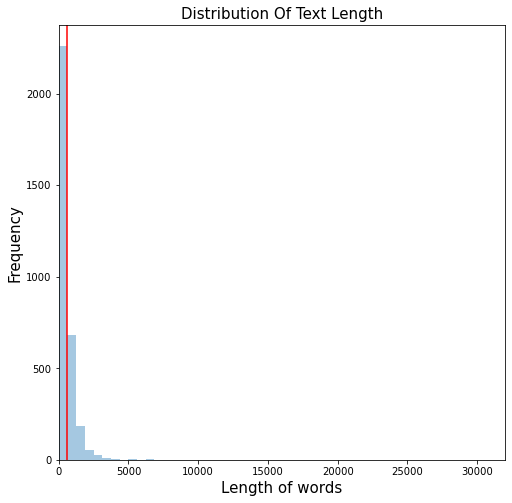

In [35]:
# Plotting a graph to visualise the distribution of text length
plt.figure(figsize= (8,8))
sns.distplot(df_final["text_length"], kde = False)
plt.title("Distribution Of Text Length", size = 15)
plt.xlabel("Length of words", size = 15)
plt.ylabel("Frequency", size = 15)
plt.axvline(np.mean(df_final["text_length"]), color = "red") #Redline is the mean
plt.xticks(size = 10)
plt.xlim(0,32000) #we have to set the upper limit to 32000 as our max value is 31157
plt.yticks(size = 10);

Average number of characters is approximately 565 with most submissions having less than 5000 characters. That said, we do have a few submissions that are extermely long (>5000 characters).

In [36]:
#Creating a new column text_word_count that contains the number of words in each status
df_final["text_word_count"] = df_final["text"].map(lambda x: len(x.split()))

In [37]:
df_final["text_word_count"].describe()

count    3238.000000
mean       88.367820
std       114.162192
min         1.000000
25%        18.000000
50%        65.000000
75%       120.000000
max      3026.000000
Name: text_word_count, dtype: float64

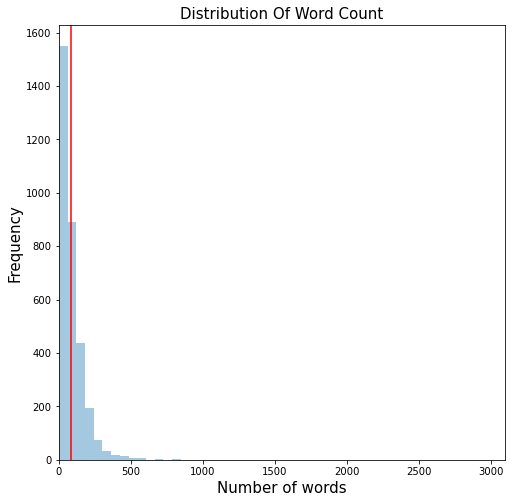

In [38]:
# Plotting a graph to visualise the distribution of text length
plt.figure(figsize= (8,8))
sns.distplot(df_final["text_word_count"], kde = False)
plt.title("Distribution Of Word Count", size = 15)
plt.xlabel("Number of words", size = 15)
plt.ylabel("Frequency", size = 15)
plt.axvline(np.mean(df_final["text_word_count"]), color = "red") #Redline is the mean
plt.xticks(size = 10)
plt.xlim(0,3100) #we have to set the upper limit to 3100 as our max value is 3026
plt.yticks(size = 10);

Average number of words is approximately 88 words with most submissions having less than 500 words. That said, we do have a few submissions that are extermely long (>500 words).

#### 3.2 5 Longest and shortest statuses 

In [39]:
# 5 longest statuses by word count
df_final.sort_values(by="text_word_count", ascending= False)[["text"]].head()

,text
1266,"Pod Launching failed: Pod took too long to start, Failed to run KubernetesPodOperator secret I'm running the quickstart for KubernetesPodOperator secret using the link below : [https://cloud.google.com/composer/docs/how-to/using/using-kubernetes-pod-operator](https://cloud.google.com/composer/docs/how-to/using/using-kubernetes-pod-operator)\n\n&amp;#x200B;\n\nCode used below :\n\n\`\`\`import datetime\n\n&amp;#x200B;\n\nfrom airflow import models\n\nfrom airflow.contrib.kubernetes import sec..."
720,"How to use Google Cloud without losing sleep About a month ago, I published a post about our incident while experimenting with GCP and Firebase. There were lot of great comments, and after the post few folks reached out to me on recommendations for their projects.\n\nIn the new year I took some time to write best practices I follow before setting up any new project on GCP that helps me to sleep well without having any on-call team.\n\nMy blog post is here: [https://sudcha.com/guide-to-cloud/..."
265,My Review of the Google Cloud Professional Cloud Architect BETA Exam Last week I sat the brand new Google Cloud Professional Cloud Architect BETA exam. I booked an available time 3 weeks out so I had enough time to go over all the new case studies and get in some study time on the architecture. I’m creating a brand new course that is specifically designed to pass this exam so I wanted to check it out and make sure that the topics I’m covering are aligned with the exam.\n\nMy high-level thoug...
1993,AWS EC2 launch configurations vs launch templates [Original Source](https://brennerm.github.io/posts/aws-launch-configuration-vs-template.html)\n\nAt first sight AWS launch configurations and templates may seem very similar. Both allow you to define a blueprint for EC2 instances. Let's have a look at their differences and see which one we should prefer.\n\n## They grow up so fast\n\nLaunch configuration are old. In terms of cloud technologies they are essentially ancient. During my research ...
189,"How to Choose the Best Cloud Platforms for your Startup In a forecast of the cloud industry by [Gartner](https://www.gartner.com/en/newsroom/press-releases/2020-11-17-gartner-forecasts-worldwide-public-cloud-end-user-spending-to-grow-18-percent-in-2021), the public cloud market was estimated to grow by 6.4% to cross $242 billion by the end of 2020 and is now [estimated](https://www.gartner.com/en/newsroom/press-releases/2020-11-17-gartner-forecasts-worldwide-public-cloud-end-user-spending-to..."


<span style="color:teal">The url links above could have been removed during data cleaning.</span>
    
<span style="color:teal">
Cleaning text in nlp :    
    
- You could remove all URLs using regex by removing all words starting with "http"
- Remove all HTML char encoding by removing all words containing #&/ and other special chars. (not just the chars themselves) (this accounts for amp and xb200 present in most of your projects
- Could also remove "[Original Source] / [community] / [guidelines] which are commonly found in reddit posts</span>

In [40]:
# 5 shortest statuses by word count
df_final.sort_values(by="text_word_count", ascending= True)[["text"]].head()

,text
153,Thoughts?
1692,twitter-post-1
739,Value
675,https://youtube.com/shorts/q_ouQmJr6ks
583,click now


<span style="color:teal">that youtube link is not very meaningful for analysis and should be removed.</span>


#### 3.3 Most frequent authors

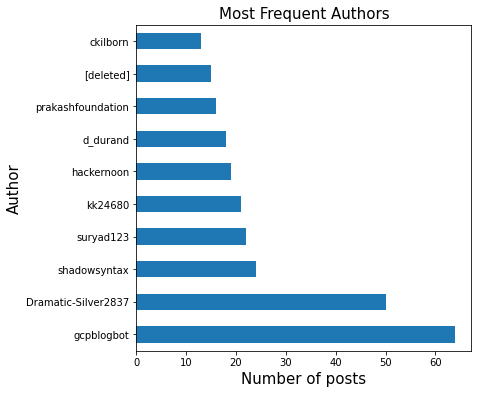

In [41]:
# Displaying the top 10 authors with the most number of posts
plt.figure(figsize= (6,6))
df_final["author"].value_counts(ascending = False).head(10).plot(kind="barh")
plt.title("Most Frequent Authors", size = 15)
plt.xlabel("Number of posts", size = 15)
plt.ylabel("Author", size = 15)
plt.xticks(size = 10)
plt.yticks(size = 10);

As a general observation, we do have a few users who posted very frequently while the rest may have barely posted. As an extension, we could also take into account the comments made by each author as a measure of activeness. However, this is not the focus of our project here.

#### 3.4 Distribution of subreddits

we will also explore the relative proportion of our two choice subreddits. This will give us an indication if we need to stratify our train-test split later to correct for any imbalances. 

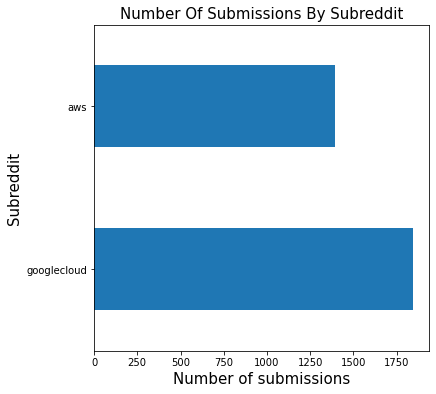

In [42]:
# Displaying the number of submissions per subreddit
plt.figure(figsize= (6,6))
df_final["subreddit"].value_counts().plot(kind="barh")
plt.title("Number Of Submissions By Subreddit", size = 15)
plt.xlabel("Number of submissions", size = 15)
plt.ylabel("Subreddit", size = 15)
plt.xticks(size = 10)
plt.yticks(size = 10);

As evident from our bar chart above, we have a slighly imbalanced dataset (i.e. more googlecloud submissions than aws submissions). This was likely due to the nature of the submission and how we cleaned our dataset. To ensure that this imbalance does not affect our modeling in any way, we will stratify our dataset when conducting train-test split later.

#### 3.5 Most common words by subreddit

As a sanity check, we should also look at the most frequent words in each subreddit. 

In order for us to perform EDA on our text column, we will need to count-vectorize it such that we: (i) remove special characters and stop words and (ii) tokenize our texts.

In [43]:
# Instantiate a CountVectorizer with the stop_words function activated
cv = CountVectorizer(stop_words="english")

In [44]:
# Fit and transform the vectorizer on our dataset
googlecloud_cv = cv.fit_transform(df_final[df_final["subreddit"] == "googlecloud"]["text"])
googlecloud_df = pd.DataFrame(googlecloud_cv.todense(), columns =cv.get_feature_names())

In [45]:
# Displaying the 15 most frequent words from our googlecloud subreddit
googlecloud_df.sum().sort_values(ascending=False).head(15)

cloud       2447
google      1833
https        968
com          842
gcp          812
amp          677
using        627
use          545
data         486
run          463
app          461
like         452
instance     401
service      391
way          367
dtype: int64

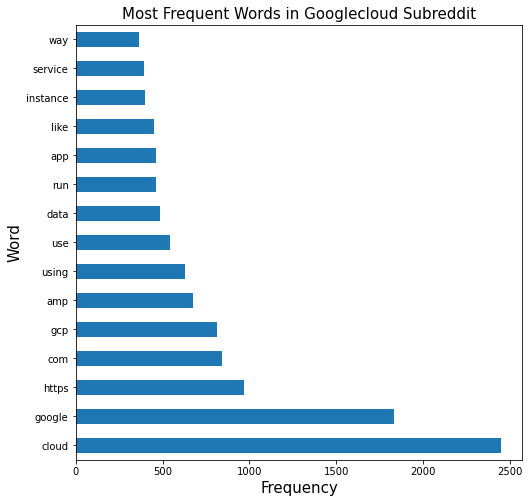

In [46]:
#Plotting the 15 most frequent words from our googlecloud subreddit
plt.figure(figsize= (8,8))
googlecloud_df.sum().sort_values(ascending=False).head(15).plot(kind="barh")
plt.title("Most Frequent Words in Googlecloud Subreddit", size = 15)
plt.xlabel("Frequency", size = 15)
plt.ylabel("Word", size = 15)
plt.xticks(size = 10)
plt.yticks(size = 10);

In [47]:
# Fit and transform the vectorizer for our aws subreddit
aws_cv = cv.fit_transform(df_final[df_final["subreddit"] == "aws"]["text"])
aws_df = pd.DataFrame(aws_cv.todense(), columns =cv.get_feature_names())

In [48]:
# Displaying the 15 most frequent words from our aws subreddit
aws_df.sum().sort_values(ascending=False).head(15)

aws         1892
using        564
https        519
use          504
com          481
s3           468
ec2          460
instance     433
like         432
lambda       407
data         376
amp          375
just         349
amazon       344
way          336
dtype: int64

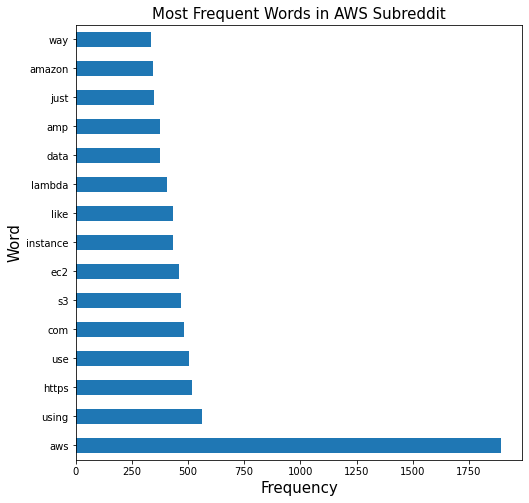

In [49]:
#Plotting the 15 most frequent words from our googlecloud subreddit
plt.figure(figsize= (8,8))
aws_df.sum().sort_values(ascending=False).head(15).plot(kind="barh")
plt.title("Most Frequent Words in AWS Subreddit", size = 15)
plt.xlabel("Frequency", size = 15)
plt.ylabel("Word", size = 15)
plt.xticks(size = 10)
plt.yticks(size = 10);

By comparing the top 15 most frequent words from each subreddit, we noticed that they are a number of words that tend to pop up in both subreddits. As such, it might be worthwhile to add these words into our default list of subreddits. 

In addition, words like "use" and "using" suggest a need to lemmatize/stem our text colums to get rid of similar words. For this project, we will go with lemmatization as it involves use of vocabulary and morphological analysis of words, aiming to remove inflectional endings only and to return the base or dictionary form of a word. Stemming, on the other hand, usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes. ([*Source: Stackoverflow*](https://stackoverflow.com/questions/1787110/what-is-the-difference-between-lemmatization-vs-stemming#:~:text=Lemmatization%20deals%20only%20with%20inflectional,requires%20some%20sort%20of%20lexica)).

#### 3.6 Customisation of stopwords list


In [50]:
# Adding more stopwords to existing list

new_stopwords = ["like", "way", "instance" , "data", 
                 "use","using","amp", "com","https"]

stopwords = stopwords.words('english')

stopwords.extend(new_stopwords)

#### 3.7 Lemmitization of our text columns

In [51]:
# Instantiating the lemmatizier and tokenizer
# The tokenizer will only keep text

lemmatizer = WordNetLemmatizer()
tokenizer  = RegexpTokenizer(r'\w+')

# Setting up the lemmatizer

lemmatized_posts = []

for i in df_final["text"]:
    tokens = tokenizer.tokenize(i)
    i = [lemmatizer.lemmatize(i) for i in tokens]
    lemmatized_posts.append(" ".join(i))
    
# Appending the lemmatized posts to the dataframe

df_final["lemmatized_text"] = lemmatized_posts

# Checking the head of the dataframe

df_final.head()

,author,title,subreddit,selftext,text,text_length,text_word_count,lemmatized_text
0,fectef,Attach persistent disk to ai platform,googlecloud,Am I correct that is it not possible to attach a persistent disk to be used from cloud ai platform (previously ml platform) and that all data has to be organized in gcs buckets?,Attach persistent disk to ai platform Am I correct that is it not possible to attach a persistent disk to be used from cloud ai platform (previously ml platform) and that all data has to be organized in gcs buckets?,215,40,Attach persistent disk to ai platform Am I correct that is it not possible to attach a persistent disk to be used from cloud ai platform previously ml platform and that all data ha to be organized in gc bucket
1,denireda31,How to present Realtime Analytics with dataflow and bigquery?,googlecloud,"Recently i watched webinar about real time analytics with pubsub, dataflow and bigquery. I understand that we can subscribe events in real time, and store it to bigquery\n\nBut sometimes to build a detail analytics we cannot rely on single event alone, we need join several tables on bigquery. I am lost at this point, how to present query result at real time?","How to present Realtime Analytics with dataflow and bigquery? Recently i watched webinar about real time analytics with pubsub, dataflow and bigquery. I understand that we can subscribe events in real time, and store it to bigquery\n\nBut sometimes to build a detail analytics we cannot rely on single event alone, we need join several tables on bigquery. I am lost at this point, how to present query result at real time?",420,72,How to present Realtime Analytics with dataflow and bigquery Recently i watched webinar about real time analytics with pubsub dataflow and bigquery I understand that we can subscribe event in real time and store it to bigquery But sometimes to build a detail analytics we cannot rely on single event alone we need join several table on bigquery I am lost at this point how to present query result at real time
2,saloni45,What are Google Cloud Services and it's Tools?,googlecloud,"Google Cloud Services is a set of Computing, Networking, Storage, Big Data, Machine Learning, and Management services offered by Google which runs on the same cloud infrastructure that Google uses internally for YouTube, Gmail, and other end-user products.\n\nWant to know more, read the blog post on [tools and services offered by Google Cloud](https://k21academy.com/google-cloud/google-cloud-services/?utm_source=reddit&amp;utm_medium=referral&amp;utm_campaign=gcp13_apr21_rgooglecloud) to lea...","What are Google Cloud Services and it's Tools? Google Cloud Services is a set of Computing, Networking, Storage, Big Data, Machine Learning, and Management services offered by Google which runs on the same cloud infrastructure that Google uses internally for YouTube, Gmail, and other end-user products.\n\nWant to know more, read the blog post on [tools and services offered by Google Cloud](https://k21academy.com/google-cloud/google-cloud-services/?utm_source=reddit&amp;utm_medium=referral&am...",549,65,What are Google Cloud Services and it s Tools Google Cloud Services is a set of Computing Networking Storage Big Data Machine Learning and Management service offered by Google which run on the same cloud infrastructure that Google us internally for YouTube Gmail and other end user product Want to know more read the blog post on tool and service offered by Google Cloud http k21academy com google cloud google cloud service utm_source reddit amp utm_medium referral amp utm_campaign gcp13_apr21_...
3,JuriJurka,How can I avoid link creation of 2 equal links simulatenously? unique link inconstistency,googlecloud,"Hi! e.g I have an app like Medium where user can post articles. Imagine 2 users post simultaneously an article called ""Pokemon is better than digimon"", the link would be mywebsite.com/pokemon-is-better-than-digimon\n\n2 cloud functions would retrieve now at 

In [52]:
#Saving that dataset
df_final.to_csv("./data/df_final.csv", index = False)

### 4. Pre-processing and modeling

#### 4.1 Mapping our subreddits into values for modeling purposes

In [53]:
#mapping the subreddit to make googlecloud =1 
df_final["subreddit"] = df_final["subreddit"].map({"googlecloud":1, "aws":0})


In [54]:
#Setting our X and y
X= df_final["lemmatized_text"]
y= df_final["subreddit"]

#### 4.2 Establishing the baseline model

A baseline model is one of the yardsticks with which we evaluate how our models are performing. Specific to the baseline model, it is simply the proportion of occurences for Googlecloud vis-a-vis that of AWS. 

In [55]:
# baseline model 
y.value_counts(normalize = True)

1    0.569487
0    0.430513
Name: subreddit, dtype: float64

From our baseline model, we will predict that a post is from the Googlecloud subreddit 56.9% of the time. 

#### 4.3 Train-test split with stratification

We will conduct train-test split for our modeling purposes. As there are imbalances in our final dataset (as established earlier), we will also stratify our train-test split.

In [56]:
# Split the data into the training and testing sets.
# Also to stratify our train-test split 
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

#### 4.4 Modeling using Logistic Regression and Multinomial Naive Bayes 

For each of these two models, we will consider both the CountVectorizer and TF-IDF Vectorizer. For the former, it turns each word into a token and counts the number of times it is featured in the whole corpus. On the other hand, the TF-IDF vectorizer  turns each word into a token but returns a term frequency (i.e. number of time a token appears/ number of total tokens in a document). This value is then scaled by the log(ratio of documents that include the token). The attractiveness of the TF-IDF vectorizer is mainly because it gives more predictive powers to words that occur often in one document but not many documents. To help us find the parameters that give us the best training and test scores, we will be deploying GridSearch for all our models. 

Specifically, we will have four models from using two vectorizers and GridSearch: 

- Logistic regression with CountVectorizer and GridSearch
- Logistic regression with TF-IDF Vectorizer and GridSearch
- Multinomial Naive Bayes with CountVectorizer and GridSearch
- Multinomial Naive Bayes with TF-IDF Vectorizer and GridSearch


#### 4.5 Evaluation Metrics

In terms of evaluation metrics, these are the standard ones that are commonly used: 


|Metric| Definition | Scale|
|---|---|---|
|Accuracy|Percentage of observations predicted correctly|0-1|
|Misclassification rate| Percentage of observations predicted wrongly|0-1|
|Specificity|Proportion of actual negatives, which got predicted as the negative |0-1|
|Sensitivity (aka recall)|Proportion of actual positive cases that got predicted as positive |0-1|
|Precision|Ratio between True Positives and all the Positives.|0-1|


For the purpose of our classification problem, we will mainly be focusing on accuracy to evaluate our models. This is because our main intent is to classify the submissions correctly into their respective subreddits and accuracy gives us a good idea of how many submissions we have accurately predicted. That said, we will look look at the other four metrics to aid our decision making process.  

#### 4.6 Logistic Regression with CountVectorizer and GridsearchCV

In [57]:
# Setting a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Logistic Regression (estimator)

pipe_lr_cvec = Pipeline([
                ("cvec", CountVectorizer()), 
                ("lr", LogisticRegression())])


In [58]:
#Defining the parameters to gridsearch
param_lr_cvec = {
    "cvec__stop_words" :[None, "english"],
    "cvec__max_features" : [100, 500, 1000, 2000, 3000, 4000, 5000],
    'cvec__ngram_range' : [(1, 1), (1,2), (2,2)],
    "lr__penalty" : ["l2"],
    'lr__C' : [0.5, 0.01,0.1, 1, 10, 100],
    "lr__max_iter": [1000],
    "lr__random_state" : [42]
}

In [59]:
# Instantiate GridSearchCV.
gs_lr_cvec = GridSearchCV(pipe_lr_cvec, param_grid = param_lr_cvec, cv = 5)

In [60]:
#Fitting pipeline to our training set
gs_lr_cvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_features': [100, 500, 1000, 2000, 3000,
                                                4000, 5000],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'lr__C': [0.5, 0.01, 0.1, 1, 10, 100],
                         'lr__max_iter': [1000], 'lr__penalty': ['l2'],
                         'lr__random_state': [42]})

In [61]:
print(f'GridSearch Best Params: {gs_lr_cvec.best_params_}')
print('Train Score:', gs_lr_cvec.score(X_train, y_train))
print('Test Score:', gs_lr_cvec.score(X_test, y_test))

GridSearch Best Params: {'cvec__max_features': 2000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'lr__C': 0.1, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__random_state': 42}
Train Score: 0.9740527182866557
Test Score: 0.9271604938271605


In [62]:
# Get predictions
preds_lr_cvec = gs_lr_cvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_lr_cvec).ravel()
print('Accuracy: {}'.format(round((tp+tn)/(tp+fp+tn+fn),4)))
print('Misclassification rate: {}'.format(round((fp+fn)/(tp+fp+tn+fn),4)))
print('Specificity: {}'.format(round(tn/(tn+fp),4)))
print('Sensitivity aka Recall: {}'.format(round(tp/(tp+fn),4)))
print('Precision: {}'.format(round(tp/(tp+fp),4)))

Accuracy: 0.9272
Misclassification rate: 0.0728
Specificity: 0.8883
Sensitivity aka Recall: 0.9566
Precision: 0.9188


#### 4.7 Logistic Regression with TF-IDF Vectorizer and GridsearchCV

In [63]:
# Setting a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Logistic Regression (estimator)

pipe_lr_tvec = Pipeline([
                ("tvec", TfidfVectorizer()), 
                ("lr", LogisticRegression())])


In [64]:
#Defining the parameters to gridsearch
param_lr_tvec = {
    "tvec__stop_words" :[None, "english"],
    'tvec__max_features': [1000,2000,3000,4000,5000],
    'tvec__ngram_range' : [(1, 1), (1,2), (2,2)],
    "lr__penalty" : ["l2"],
    'lr__C' : [0.5, 0.01,0.1, 1, 10, 100],
    "lr__max_iter": [1000],
    "lr__random_state" : [42]
}

In [65]:
# Instantiate GridSearchCV.
gs_lr_tvec = GridSearchCV(pipe_lr_tvec, param_grid = param_lr_tvec, cv = 5)

In [66]:
#Fitting pipeline to our training set
gs_lr_tvec.fit(X_train, y_train);

In [67]:
print(f'GridSearch Best Params: {gs_lr_tvec.best_params_}')
print('Train Score:', gs_lr_tvec.score(X_train, y_train))
print('Test Score:', gs_lr_tvec.score(X_test, y_test))

GridSearch Best Params: {'lr__C': 1, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__random_state': 42, 'tvec__max_features': 3000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}
Train Score: 0.979818780889621
Test Score: 0.9382716049382716


In [68]:
# Get predictions
preds_lr_tvec = gs_lr_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_lr_tvec).ravel()
print('Accuracy: {}'.format(round((tp+tn)/(tp+fp+tn+fn),4)))
print('Misclassification rate: {}'.format(round((fp+fn)/(tp+fp+tn+fn),4)))
print('Specificity: {}'.format(round(tn/(tn+fp),4)))
print('Sensitivity aka Recall: {}'.format(round(tp/(tp+fn),4)))
print('Precision: {}'.format(round(tp/(tp+fp),4)))

Accuracy: 0.9383
Misclassification rate: 0.0617
Specificity: 0.8854
Sensitivity aka Recall: 0.9783
Precision: 0.9185


#### 4.8 Multinomial Naive Bayes with CountVectorizer and GridsearchCV

In [69]:
# Setting a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe_nb_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [70]:
#Defining the parameters to gridsearch
param_nb_cvec = {
    "cvec__stop_words" :[None, "english"],
    "cvec__max_features" : [100, 500, 1000, 2000, 3000, 4000, 5000],
    'cvec__ngram_range' : [(1, 1), (1,2), (2,2)],
    "nb__fit_prior": [True, False]
}


In [71]:
# Instantiate GridSearchCV.
gs_nb_cvec = GridSearchCV(pipe_nb_cvec, 
                  param_grid=param_nb_cvec, 
                  cv=5)

In [72]:
#Fitting pipeline to our training set
gs_nb_cvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_features': [100, 500, 1000, 2000, 3000,
                                                4000, 5000],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'nb__fit_prior': [True, False]})

In [73]:
print(f'GridSearch Best Params: {gs_nb_cvec.best_params_}')
print('Train Score:', gs_nb_cvec.score(X_train, y_train))
print('Test Score:', gs_nb_cvec.score(X_test, y_test))

GridSearch Best Params: {'cvec__max_features': 5000, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'nb__fit_prior': True}
Train Score: 0.96334431630972
Test Score: 0.9234567901234568


In [74]:
# Get predictions
preds_nb_cvec = gs_nb_cvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_nb_cvec).ravel()
print('Accuracy: {}'.format(round((tp+tn)/(tp+fp+tn+fn),4)))
print('Misclassification rate: {}'.format(round((fp+fn)/(tp+fp+tn+fn),4)))
print('Specificity: {}'.format(round(tn/(tn+fp),4)))
print('Sensitivity aka Recall: {}'.format(round(tp/(tp+fn),4)))
print('Precision: {}'.format(round(tp/(tp+fp),4)))

Accuracy: 0.9235
Misclassification rate: 0.0765
Specificity: 0.9112
Sensitivity aka Recall: 0.9328
Precision: 0.9328


#### 4.9 Multinomial Naive Bayes with TF-IDF Vectorizer and GridsearchCV

In [75]:
# Setting a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)
pipe_nb_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [76]:
#Defining the parameters to gridsearch
param_nb_tvec = {
    "tvec__stop_words" :[None, "english"],
    'tvec__max_features': [1000,2000,3000,4000,5000],
    'tvec__ngram_range' : [(1, 1), (1,2), (2,2)],
     "nb__fit_prior": [True, False]
}

In [77]:
# Instantiate GridSearchCV.
gs_nb_tvec = GridSearchCV(pipe_nb_tvec, 
                  param_grid=param_nb_tvec, 
                  cv=5)

In [78]:
#Fitting pipeline to our training set
gs_nb_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'nb__fit_prior': [True, False],
                         'tvec__max_features': [1000, 2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [None, 'english']})

In [79]:
print(f'GridSearch Best Params: {gs_nb_tvec.best_params_}')
print('Train Score:', gs_nb_tvec.score(X_train, y_train))
print('Test Score:', gs_nb_tvec.score(X_test, y_test))

GridSearch Best Params: {'nb__fit_prior': False, 'tvec__max_features': 5000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}
Train Score: 0.9662273476112027
Test Score: 0.9308641975308642


In [80]:
# Get predictions
preds_nb_tvec = gs_nb_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_nb_tvec).ravel()
print('Accuracy: {}'.format(round((tp+tn)/(tp+fp+tn+fn),4)))
print('Misclassification rate: {}'.format(round((fp+fn)/(tp+fp+tn+fn),4)))
print('Specificity: {}'.format(round(tn/(tn+fp),4)))
print('Sensitivity aka Recall: {}'.format(round(tp/(tp+fn),4)))
print('Precision: {}'.format(round(tp/(tp+fp),4)))

Accuracy: 0.9309
Misclassification rate: 0.0691
Specificity: 0.9112
Sensitivity aka Recall: 0.9458
Precision: 0.9336


#### 4.10 Model Selection and Result Interpretation

Based on the four models that we have gridsearch-ed, we first look at their individual training and test scores to identify the one model that has the highest accuracy (i.e. correctly predicting the subreddit class). 

|Model| Training Score | Test Score |
|---|---|---|
|Logistic regression with CV and GS|0.9740|0.9272|
|Logistic Regression with TV and GS| 0.9798|0.9383|
|Multinomial Naive Bayes with CV and GS|0.9633|0.9235|
|Multinomial Naive Bayes with TV and GS|0.9662|0.9309|

While our four models have relatively similar training scores, the test score for our Logistic Regression with TV and GS is the highest. This suggests that the model is best (amongst all 4 models) at correctly predicting the submissions in the test set (i.e. unseen data). As we are ultimately interested in correctly classifying the submissions into their respective subreddits so that we can conduct our sentiment analysis (i.e. our problem statement), our choice model should be that of Logistic Regression with TV and GS (best params from GS are: (lr__C = 1;  lr__max_iter =  1000; lr__penalty = l2; lr__random_state = 42; tvec__max_features = 3000; tvec__ngram_range = (1, 2); tvec__stop_words = english). 

From our Logistic Regression with TV and GS model, we also obtained the following evaluation metrics: 

- Accuracy: 0.9383  
- Misclassification rate: 0.0617 
- Specificity: 0.8854 
- Sensitivity aka Recall: 0.9783
- Precision: 0.9185

The interpretations of these numbers are as such:
- Our model correctly predicts 93.83% of the test observations. Accordingly, our model inaccurately predicts 6.17% of the test observations.
- Among posts that are in r/aws, our model has 88.54% of the classified accurately
- Among posts that are in r/googlecloud, our model has 97.83% of them classified accurately
- Among posts that are predicted as r/googlecloud, we have 91.85% of them classified accurately. 

Figure below also shows the confusion matrix for our Logistic Regression with TV and GS model

<span style="color:teal">could explore why log reg did better than naiive bayes.
</span>

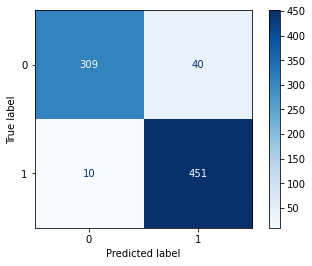

In [81]:
# Confusion matrix for Logistic Regression with TV and GS model
plot_confusion_matrix(gs_lr_tvec, X_test, y_test, cmap='Blues', values_format='d');

<span style="color:teal">could elaborate more about this confusion matrix. look into the FPs / FNs. why these are not classified properly, and from there can make changes to improve the model.</span>


#### 4.11 Sentiment analysis

As we set out earlier in our problem statement, we are interested how consumers are feeling about Google Cloud vis-a-vis that of AWS. As such, we will seek to classify the submissions (from both r/googlecloud and r/aws) into having positive or negative emotion. We will do so using the VADER (Valence Aware Dictionary and sEntiment reasoner).

In [82]:
#Importing VADER library
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [83]:
# Instantiate Sentiment Intensity Analyzer
sent = SentimentIntensityAnalyzer()

In [84]:
#Setting a function to feed our "lemmatized_text" into sent for analysis
results = []

for submission in df_final["lemmatized_text"]:
    '''
    Input is the individual rows in lemmatized_text.We then put them through the 
    sentiment intensity analyzer iteratively and append the results in an empty list (i.e. results)
    '''
    pol_score = sent.polarity_scores(submission)
    results.append(pol_score)


In [85]:
#Printing our list of results
results

[{'neg': 0.0, 'neu': 0.939, 'pos': 0.061, 'compound': 0.34},
 {'neg': 0.06, 'neu': 0.909, 'pos': 0.031, 'compound': -0.2732},
 {'neg': 0.0, 'neu': 0.984, 'pos': 0.016, 'compound': 0.0772},
 {'neg': 0.057, 'neu': 0.831, 'pos': 0.112, 'compound': 0.4678},
 {'neg': 0.191, 'neu': 0.637, 'pos': 0.172, 'compound': -0.0772},
 {'neg': 0.0, 'neu': 0.891, 'pos': 0.109, 'compound': 0.5423},
 {'neg': 0.0, 'neu': 0.699, 'pos': 0.301, 'compound': 0.6808},
 {'neg': 0.0, 'neu': 0.714, 'pos': 0.286, 'compound': 0.4215},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.028, 'neu': 0.94, 'pos': 0.032, 'compound': 0.0772},
 {'neg': 0.0, 'neu': 0.873, 'pos': 0.127, 'compound': 0.8402},
 {'neg': 0.0, 'neu': 0.892, 'pos': 0.108, 'compound': 0.4404},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.046, 'neu': 0.873, 'pos': 0.081, 'compound': 0.838},
 {'neg': 0.0, 'neu': 0.941, 'pos': 0.059, 'compound': 0.25},
 {'neg':

In [86]:
#Setting our list into a dataframe for subsequent concatenation with our final dataset
sent_analysis = pd.DataFrame(results)

In [87]:
#Shape of sent_analysis
sent_analysis.shape

(3238, 4)

In [88]:
#Before we concatenate the datasets, we have to reset their indexes 
df_final.reset_index(drop=True, inplace=True)
sent_analysis.reset_index(drop=True, inplace=True)

In [89]:
#Concatenating two datasets into one for further analysis
df_final = pd.concat([df_final, sent_analysis], axis = 1)

In [90]:
#Printing first five rows of our concatenated dataset
df_final.head()

,author,title,subreddit,selftext,text,text_length,text_word_count,lemmatized_text,neg,neu,pos,compound
0,fectef,Attach persistent disk to ai platform,1,Am I correct that is it not possible to attach a persistent disk to be used from cloud ai platform (previously ml platform) and that all data has to be organized in gcs buckets?,Attach persistent disk to ai platform Am I correct that is it not possible to attach a persistent disk to be used from cloud ai platform (previously ml platform) and that all data has to be organized in gcs buckets?,215,40,Attach persistent disk to ai platform Am I correct that is it not possible to attach a persistent disk to be used from cloud ai platform previously ml platform and that all data ha to be organized in gc bucket,0.000,0.939,0.061,0.3400
1,denireda31,How to present Realtime Analytics with dataflow and bigquery?,1,"Recently i watched webinar about real time analytics with pubsub, dataflow and bigquery. I understand that we can subscribe events in real time, and store it to bigquery\n\nBut sometimes to build a detail analytics we cannot rely on single event alone, we need join several tables on bigquery. I am lost at this point, how to present query result at real time?","How to present Realtime Analytics with dataflow and bigquery? Recently i watched webinar about real time analytics with pubsub, dataflow and bigquery. I understand that we can subscribe events in real time, and store it to bigquery\n\nBut sometimes to build a detail analytics we cannot rely on single event alone, we need join several tables on bigquery. I am lost at this point, how to present query result at real time?",420,72,How to present Realtime Analytics with dataflow and bigquery Recently i watched webinar about real time analytics with pubsub dataflow and bigquery I understand that we can subscribe event in real time and store it to bigquery But sometimes to build a detail analytics we cannot rely on single event alone we need join several table on bigquery I am lost at this point how to present query result at real time,0.060,0.909,0.031,-0.2732
2,saloni45,What are Google Cloud Services and it's Tools?,1,"Google Cloud Services is a set of Computing, Networking, Storage, Big Data, Machine Learning, and Management services offered by Google which runs on the same cloud infrastructure that Google uses internally for YouTube, Gmail, and other end-user products.\n\nWant to know more, read the blog post on [tools and services offered by Google Cloud](https://k21academy.com/google-cloud/google-cloud-services/?utm_source=reddit&amp;utm_medium=referral&amp;utm_campaign=gcp13_apr21_rgooglecloud) to lea...","What are Google Cloud Services and it's Tools? Google Cloud Services is a set of Computing, Networking, Storage, Big Data, Machine Learning, and Management services offered by Google which runs on the same cloud infrastructure that Google uses internally for YouTube, Gmail, and other end-user products.\n\nWant to know more, read the blog post on [tools and services offered by Google Cloud](https://k21academy.com/google-cloud/google-cloud-services/?utm_source=reddit&amp;utm_medium=referral&am...",549,65,What are Google Cloud Services and it s Tools Google Cloud Services is a set of Computing Networking Storage Big Data Machine Learning and Management service offered by Google which run on the same cloud infrastructure that Google us internally for YouTube Gmail and other end user product Want to know more read the blog post on tool and service offered by Google Cloud http k21academy com google cloud google cloud service utm_source reddit amp utm_medium referral amp utm_campaign gcp13_apr21_...,0.000,0.984,0.016,0.0772
3,JuriJurka,How can I avoid link creation of 2 equal links simulatenously? unique link inconstistency,1,"Hi! e.g I have an app like Medium where user can post articles. Imagine 2 users post simultaneously an article called ""Pokemon is better than digimon"", the link would be mywebsite.com/pokemon-is-better

In [91]:
#Saving the concatenated dataset 
df_final.to_csv("./data/df_final.csv", index = False)

In [92]:
#Looking at the average polarity scores by subreddit
df_final.groupby(by = df_final["subreddit"]).mean()

,text_length,text_word_count,neg,neu,pos,compound
subreddit,,,,,,
0,577.541607,91.911047,0.032283,0.862068,0.105656,0.407888
1,554.948482,85.689262,0.031826,0.864719,0.103460,0.370135


In [93]:
#Creating a sub-dataset where subreddit =1 (i.e. google cloud)
df_google_sent_analysis = df_final[df_final["subreddit"] == 1]

<Figure size 864x864 with 0 Axes>

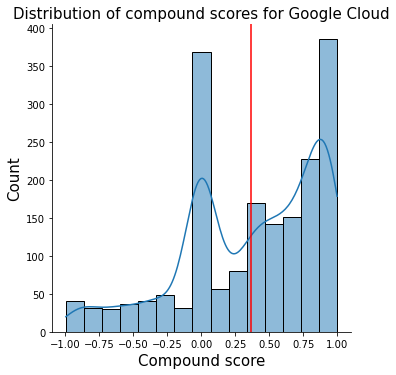

In [94]:
# Plotting the distribution of compound scores for google cloud
plt.figure(figsize= (12,12))
sns.displot(df_google_sent_analysis, x="compound", kde = True)
plt.title("Distribution of compound scores for Google Cloud", size = 15)
plt.ylabel("Count", size = 15)
plt.xlabel("Compound score", size = 15)
plt.axvline(np.mean(df_google_sent_analysis["compound"]), color = "red")
plt.xticks(size = 10)
plt.yticks(size = 10);

In [95]:
#Creating a sub-dataset where subreddit =0 (i.e. aws)
df_aws_sent_analysis = df_final[df_final["subreddit"] == 0]

<Figure size 864x864 with 0 Axes>

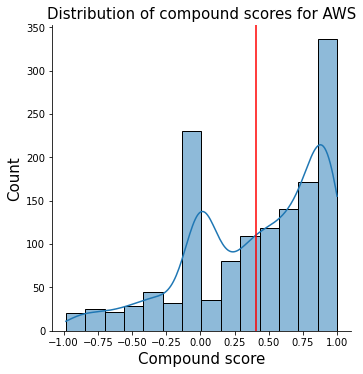

In [96]:
# Plotting the distribution of compound scores for aws
plt.figure(figsize= (12,12))
sns.displot(df_aws_sent_analysis, x="compound", kde = True)
plt.title("Distribution of compound scores for AWS", size = 15)
plt.ylabel("Count", size = 15)
plt.xlabel("Compound score", size = 15)
plt.axvline(np.mean(df_aws_sent_analysis["compound"]), color = "red")
plt.xticks(size = 10)
plt.yticks(size = 10);

Observation: 

From our compound scores (calculated by normalizing the scores for negative, neutral and postive) for GoogleCloud vis-a-vis AWS (0.3698 vs 0.4073; as per the red lines in our diagrams), the general conclusion is that both subreddits follow a very similar distribution with clustering around the 0.00 and 1.00 scores. That said,  AWS has slighlty more positive sentiments than GoogleCloud . That said, we can also observe that AWS has a marginally higher negative score than GoogleCloud  (i.e. AWS is more polarised at both ends of the spectrum while GoogleCloud  is slightly more netural). Armed with these sentiment results, we can come up with some recommendations to improve Google's offerings (see Section 5.0 Conclusion and Recommendations).

### 5. Conclusion and Recommendations

#### 5.1 Recap of Problem Statement

You are a junior data scientist who was recently hired by Google to analyse big data and improve its standing and product offerings. As Cloud technology is fast arising and adopted by many companies, you decided to examine the sentiments of Google Cloud vis-a-vis that of Amazon Web Services (i.e. Google's fierce competitor in the market). To do so, you wanted to use a set of subreddit submissions prepared by your predecessor who had recently left Google for greener pastures. Unfortunately, upon inspection of the dataset, you realised that he had accidentally left out the identification tagging column. This makes it difficult to accurately classify the subreddits into Google Cloud and AWS. In order to salvage the situation and use the dataset, you would thus have to first build several Natural Language Processing (NLP) models to attempt to classify subreddit submissions (from r/googlecloud and r/aws) correctly. Following which, we will choose the best performing model using the accuracy score(i.e. percentage of observations predicted correctly).

#### 5.2 Conclusion

In coming up with a model to classify submissions from r/googlecloud and r/aws, we found that our Logistic Regression with TF-IDF Vectorizer and GridSearch produces the best test accuracy score of 93.93 (i.e. correctly classifying 93.83% of test observations into their rightful subreddits). This phenomenon is not entirely surprising as there could be commonly used keywords that are specific to each subreddit, thereby making it easier for our model to learn and predict their subreddits. 

As set out in our problem statement, we are actually also interested in the sentiments of Google Cloud vis-a-vis AWS. Using the VADER (Valence Aware Dictionary and sEntiment reasoner), we found that Google Cloud's compound score is 0.3698 vs 0.4073 for AWS. As such, AWS has slightly more positive sentiments. Interestingly, when looking at the negative scores, we also observe that AWS has marginally higher scores, thereby suggesting that AWS' sentiments are more polarised at both ends of the spectrum while Google Cloud's are slightly more netural.


#### 5.3 Recommendations

Armed with our classifier and sentiment results, we could now: 
- Run our classifer on the dataset left behind by our predecessor to tag each submission into their respective subreddits
- Analyse sentiment results based on that particular dataset

In the interim, some prelim recommendations we can make based on the set of sentiment results to improve Google's standing and product offerings are: 
- Improve features of Google Cloud to make product differentiation more explicit
- Improve on after-sale/troubleshooting services for better customer experience which wil tend translate to higher customer satisfaction

To ensure a more holistic understanding, we could consider further extensions such as:

- Supplementing existing sentiment results with comments (and not just submissions)
- Analysing overall subreddits between Google and its competitors (i.e. r/google vs r/competitors)
- Analysing other cloud-related subreddits (e.g. Microsoft Azure)
- Analysing subreddits from other product offerings (e.g. Google Home/Pixel)
